1.Problem Statement:

"We model the motion of a cricket ball thrown from the boundary to the wicketkeeper. The trajectory is parabolic but distorted due to air drag. The goal is to estimate the position of the ball every millisecond using noisy and incomplete sensor measurements."

In [13]:
import numpy as np
import matplotlib.pyplot as plt

2.Assumptions:

a.2D motion.
b.Air resistance proportional to velocity.
c.Constant gravity.
d.Initial velocity at 45°.
e.Sensor measurements are noisy, biased, and have occasional dropouts.

In [14]:
# Constants and Assumptions

g = 9.81       # Gravity
k = 0.05       # Drag factor
dt = 0.001     # Time step
T = 2.5        # Total time
n = int(T / dt)


### 3.Governing Equations


**Newton’s Second Law:**

$$\vec{a} = \begin{bmatrix} -k \cdot v_x \\ -g - k \cdot v_y \end{bmatrix}$$

**Position Update:**


$$\vec{x}_{t+1} = \vec{x}_t + \vec{v}_t \cdot dt$$

**Velocity Update:**
$$\vec{v}_{t+1} = \vec{v}_t + \vec{a} \cdot dt$$

In [15]:
# Initial position and velocity (45-degree launch)
v0 = 40.0
p0 = np.array([0.0, 0.0])
v = np.array([v0 / np.sqrt(2), v0 / np.sqrt(2)])

4.Use standard notations:

z_t: measurement

x̂_t: estimated position

x_t: true position

v_t: velocity

η: noise

In [16]:
# Simulate true path
p = p0.copy()
true_p, true_v = [], []

for _ in range(n):
    a = np.array([-k * v[0], -g - k * v[1]])
    v += a * dt
    p += v * dt

    true_p.append(p.copy())
    true_v.append(v.copy())

    if p[1] < 0:
        break

true_p = np.array(true_p)
true_v = np.array(true_v)

In [17]:
# Sampling for readability
s = 10
true_p_s = true_p[::s]

In [18]:
# Generate noisy measurements
def get_obs(data, noise=2.0, bias_p=0.05, drop_p=0.05):
    obs = []
    for d in data:
        if np.random.rand() < drop_p:
            obs.append(None)
            continue

        bias = np.random.uniform(-5, 5, 2) if np.random.rand() < bias_p else np.zeros(2)
        noisy = d + np.random.normal(0, noise, 2) + bias
        obs.append(noisy)
    return np.array(obs, dtype=object)

z = get_obs(true_p_s)

In [19]:
# Filter function
def bayes_filter(z, p0, v0):
    est = []
    x = np.array(p0)
    v = np.array(v0)

    for m in z:
        x_p = x + v * dt * s
        a_p = np.array([-k * v[0], -g - k * v[1]])
        v_p = v + a_p * dt * s

        if m is not None:
            err = m - x_p
            x = x_p + 0.2 * err
            v = v_p + 0.1 * err / (dt * s)
        else:
            x = x_p
            v = v_p

        est.append(x.copy())

    return np.array(est)

est_p = bayes_filter(z, p0, v)

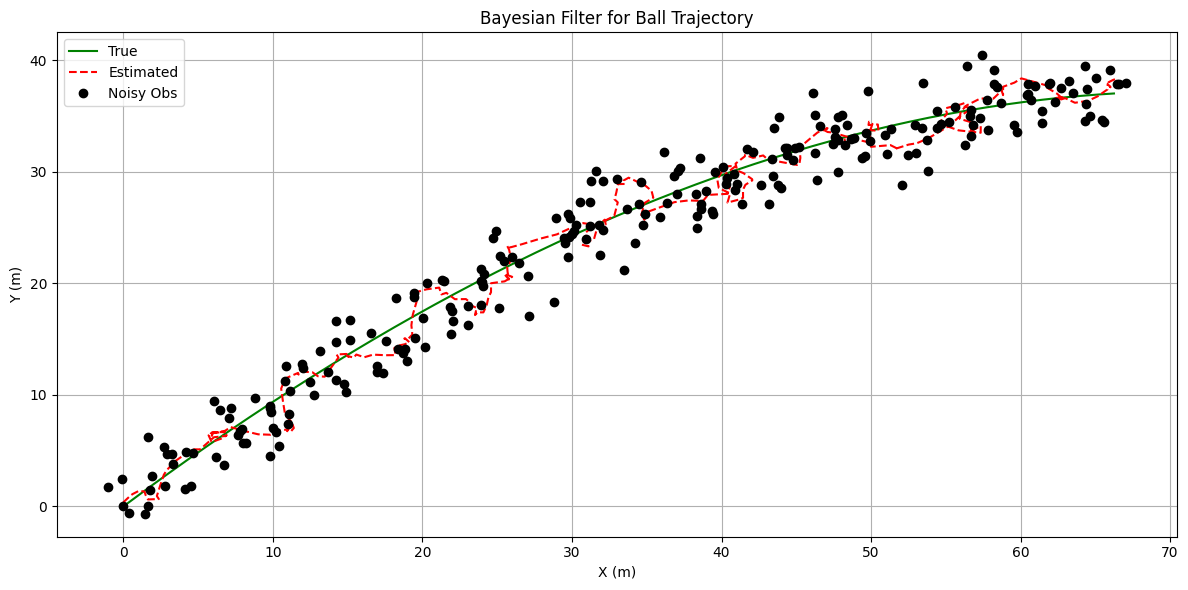

In [20]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(true_p_s[:, 0], true_p_s[:, 1], 'g-', label='True')
plt.plot(est_p[:, 0], est_p[:, 1], 'r--', label='Estimated')

zx = [i[0] if i is not None else None for i in z]
zy = [i[1] if i is not None else None for i in z]
plt.plot(zx, zy, 'ko', label='Noisy Obs')

plt.title("Bayesian Filter for Ball Trajectory")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Flowchart Steps for Cricket Ball Trajectory Estimation**

1.  **Problem Definition:** State the goal of estimating the ball's trajectory with air resistance from noisy sensor data.
2.  **Assumptions & Governing Formulae:** List the key assumptions and present the physics equations (Newton's 2nd Law, position/velocity updates) .
3.  **Simulation Setup:** Define constants (gravity, drag, time step) and initial launch conditions.
4.  **True Path Simulation & Data Generation:** Simulate the actual ball trajectory and then create synthetic noisy, biased, and potentially dropped sensor measurements.
5.  **Bayesian Filter Implementation:** Define the filter function, explaining the **prediction** (prior) and **update** (posterior) steps.
6.  **Results & Visualization:** Run the filter and plot the true path, noisy observations, and the filter's estimated path.
7.  **Discussion & Conclusion:** Analyze the filter's performance, discuss limitations, and suggest improvements.